# Road Segmentation


En este ejemplo vamos a entrenar el modelo de Deep Learning para encontrar carreteras en imágenes satelitales que hemos utilizado en la demostración de SCANEO, siguiendo el trabajo [aquí](https://github.com/aavek/Satellite-Image-Road-Segmentation/tree/main?tab=readme-ov-file).


## Dataset


El conjunto de datos que utilizaremos es [Deep Globe Road Extraction](https://www.eotdl.com/datasets/DeepGlobeRoadExtraction). Contiene 6226 imágenes satelitales en RGB, tamaño 1024x1024, con una resolución de 50 cm, capturadas por el satélite de DigitalGlobe.


In [1]:
from pytorch_eo.datasets import DeepGlobeRoadExtraction

ds = DeepGlobeRoadExtraction(batch_size=5)

ds.setup()

Staging assets: 100%|██████████| 1/1 [03:27<00:00, 207.25s/it]


In [2]:
ds.df

image  \
0     data/DeepGlobeRoadExtraction/train/100034_sat.jpg   
1     data/DeepGlobeRoadExtraction/train/100081_sat.jpg   
2     data/DeepGlobeRoadExtraction/train/100129_sat.jpg   
3     data/DeepGlobeRoadExtraction/train/100703_sat.jpg   
4     data/DeepGlobeRoadExtraction/train/100712_sat.jpg   
...                                                 ...   
6221  data/DeepGlobeRoadExtraction/train/999431_sat.jpg   
6222  data/DeepGlobeRoadExtraction/train/999531_sat.jpg   
6223  data/DeepGlobeRoadExtraction/train/999667_sat.jpg   
6224  data/DeepGlobeRoadExtraction/train/999764_sat.jpg   
6225   data/DeepGlobeRoadExtraction/train/99995_sat.jpg   

                                                   mask  
0     data/DeepGlobeRoadExtraction/train/100034_mask...  
1     data/DeepGlobeRoadExtraction/train/100081_mask...  
2     data/DeepGlobeRoadExtraction/train/100129_mask...  
3     data/DeepGlobeRoadExtraction/train/100703_mask...  
4     data/DeepGlobeRoadExtraction/train/100712_mask...  
...                                                 ...  
6221  data/DeepGlobeRoadExtraction/train/999431_mask...  
6222  data/DeepGlobeRoadExtraction/train/999531_mask...  
6223  data/DeepGlobeRoadExtraction/train/999667_mask...  
6224  data/DeepGlobeRoadExtraction/train/999764_mask...  
6225  data/DeepGlobeRoadExtraction/train/99995_mask.png  

[6226 rows x 2 columns]

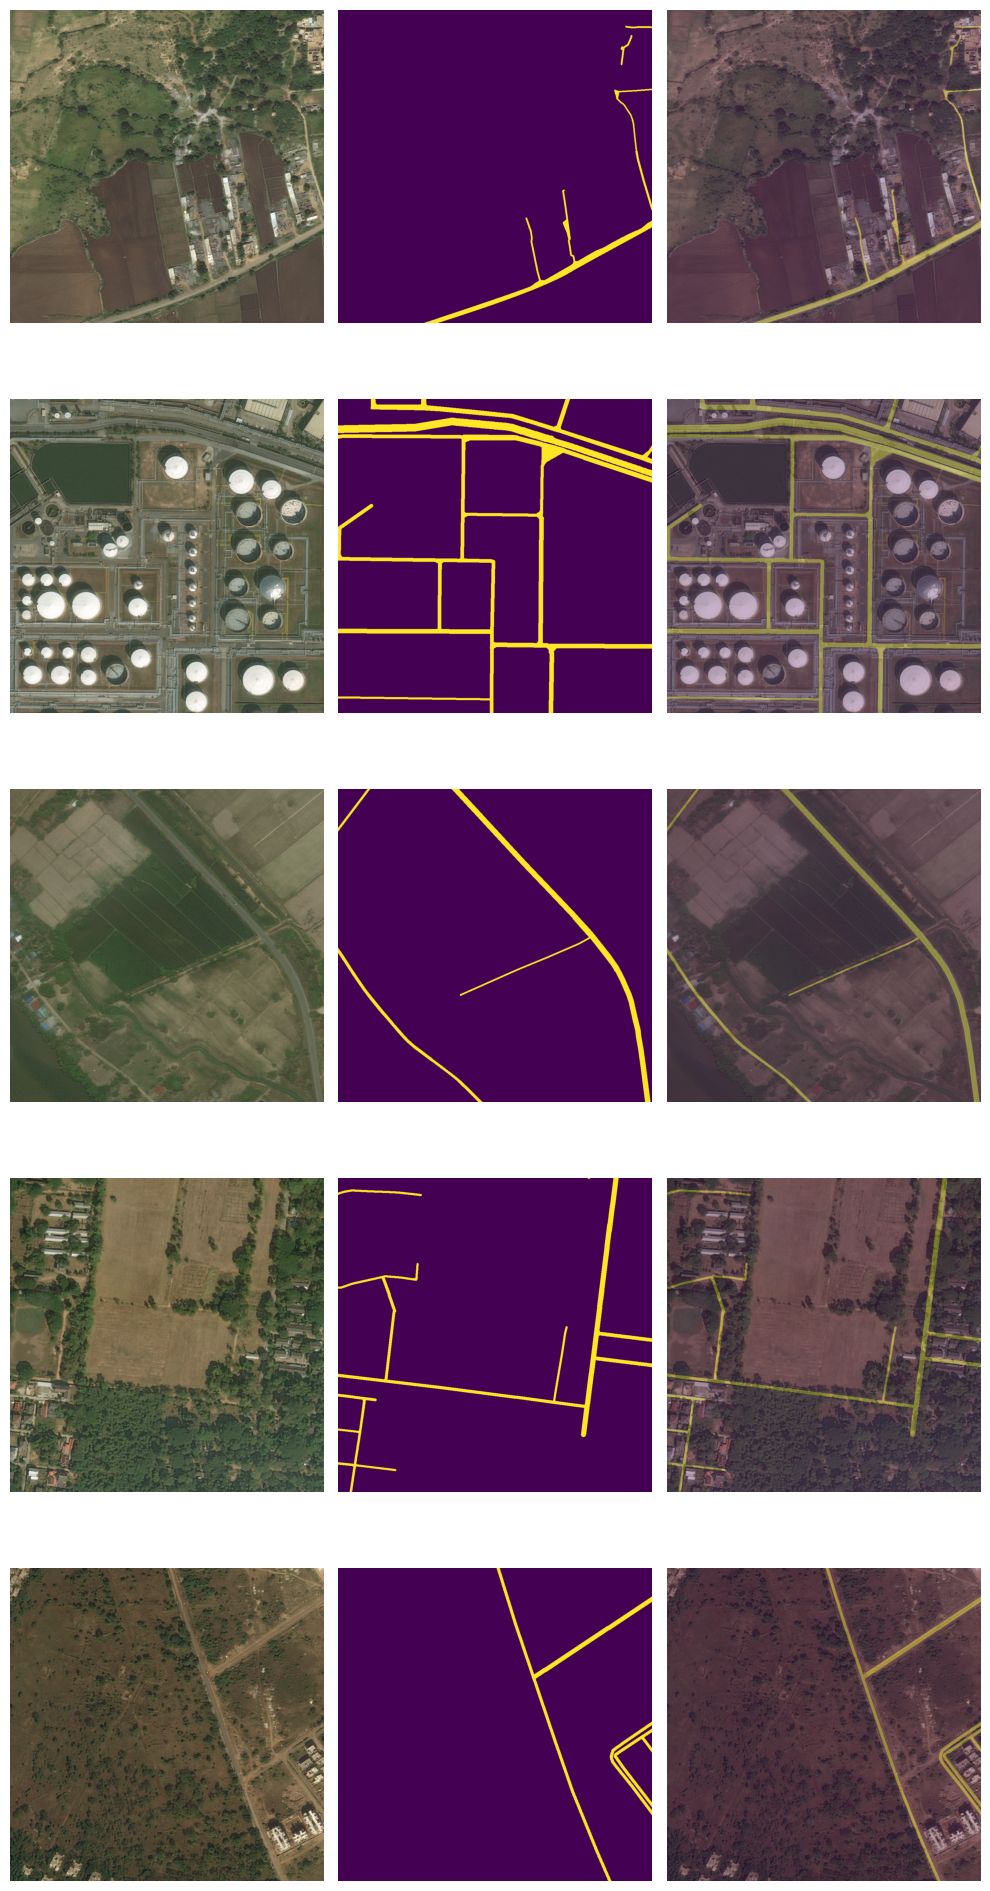

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

batch = next(iter(ds.train_dataloader()))
imgs, masks = batch["image"], batch["mask"]

imgs = rearrange(imgs, "b c h w -> b h w c")
masks = masks.squeeze(1)

fig = plt.figure(figsize=(10, len(imgs) * 4))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    ax = plt.subplot(len(imgs), 3, 3 * i + 1)
    ax.imshow(img)
    ax.axis("off")
    ax = plt.subplot(len(imgs), 3, 3 * i + 2)
    ax.imshow(mask)
    ax.axis("off")
    ax = plt.subplot(len(imgs), 3, 3 * i + 3)
    ax.imshow(img)
    ax.imshow(mask, alpha=0.3)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Entrenamiento


Vamos a entrenar un modelo U-Net con parámetros predeterminados. Puedes ver un ejemplo avanzado en [road_segmentation.py](https://github.com/earthpulse/pytorchEO/blob/main/examples/road_segmentation.py).


In [4]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_eo.tasks import ImageSegmentation

ds_trainer = DeepGlobeRoadExtraction(batch_size=8, num_workers=20, pin_memory=True)

task = ImageSegmentation(num_classes=ds_trainer.num_classes)

trainer = L.Trainer(
    # accelerator="cuda",   # descomentar para usar GPU
    accelerator="cpu",
    devices=1,
    max_epochs=10,
    limit_train_batches=10,  # comment this line to train on the full dataset
    limit_val_batches=10,  # comment this line to validate on the full dataset
    callbacks=[
        ModelCheckpoint(
            monitor="val_iou",
            mode="max",
            save_top_k=1,
            dirpath="checkpoints",
            filename="unet-{epoch:02d}-{val_iou:.2f}",
        )
    ],
)

# uncomment the following line to train the model
# trainer.fit(task, ds_trainer)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/fran/Documents/dev/workshop-jsl-2025/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/fran/Documents/dev/workshop-jsl-2025/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


## Evaluar


Podemos visualizar los resultados del modelo


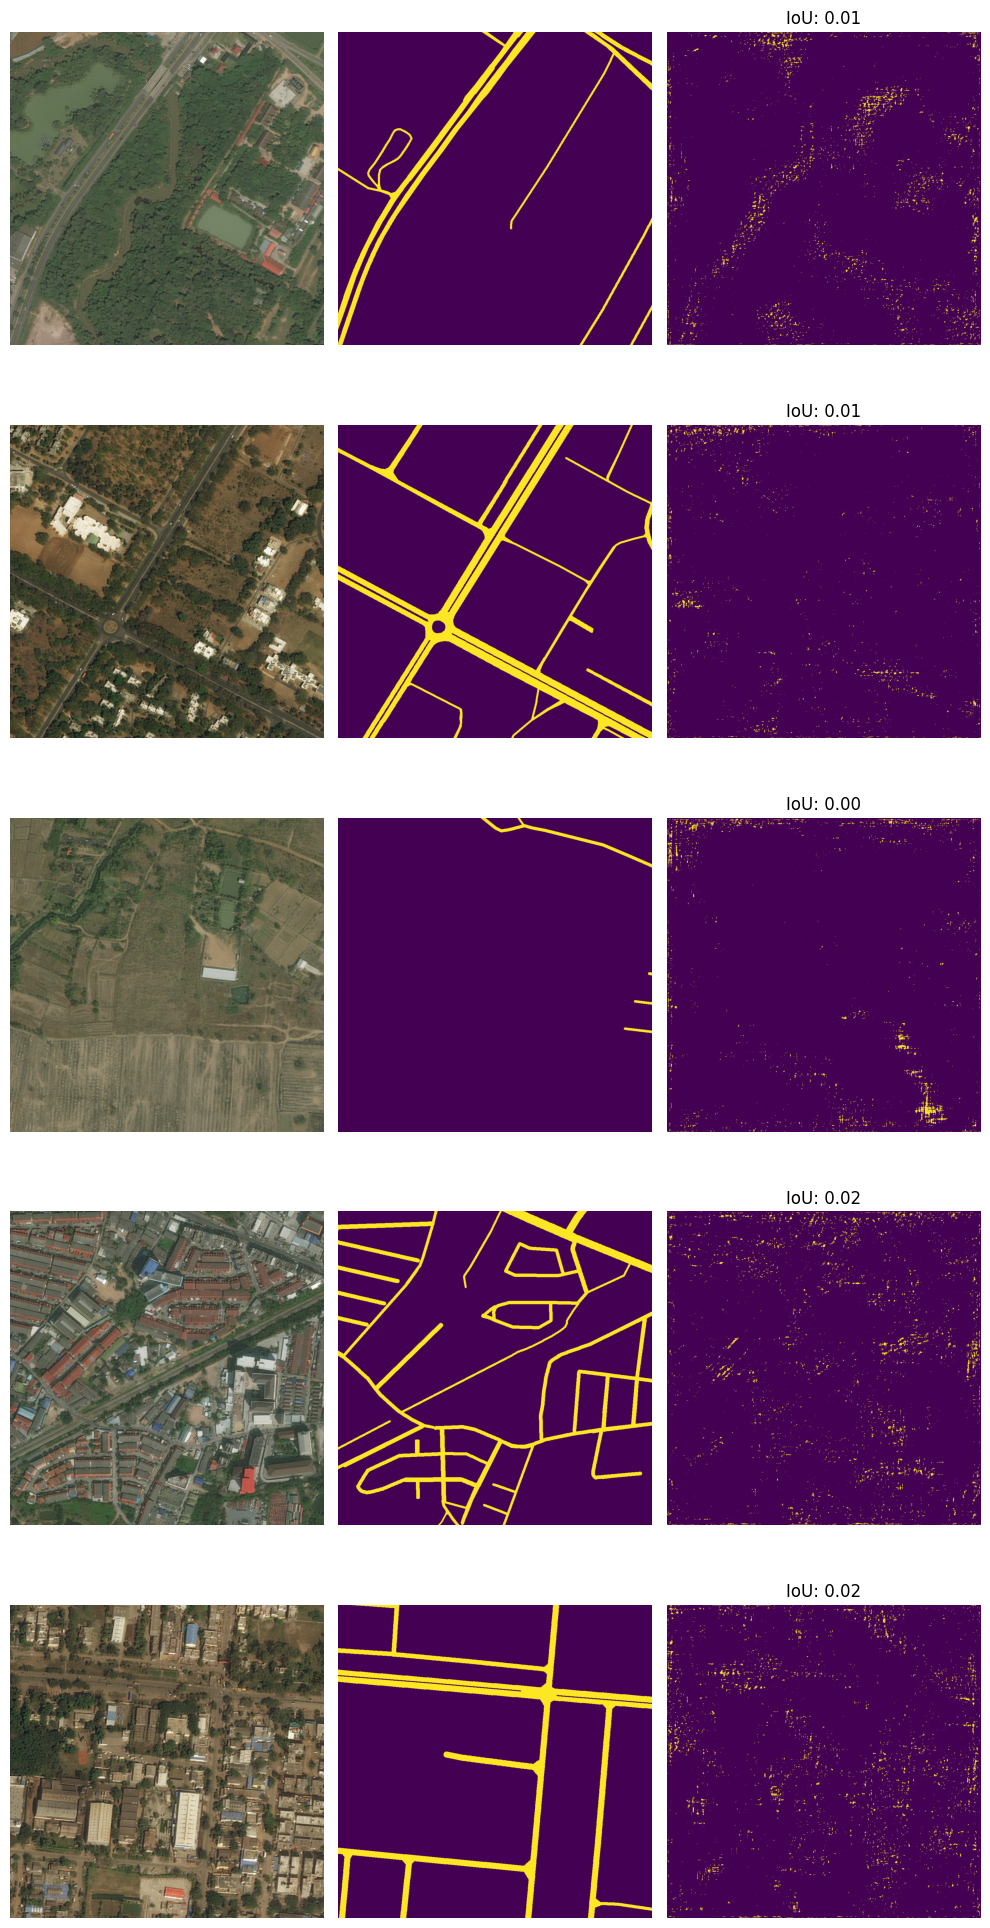

In [6]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from pytorch_eo.metrics.segmentation import iou

# ds = DeepGlobeRoadExtraction(batch_size=5)
# ds.setup()

batch = next(iter(ds.val_dataloader()))
imgs, masks = batch["image"], batch["mask"]

task.cpu()
preds = task.predict(batch) > 0.5

imgs = rearrange(imgs, "b c h w -> b h w c")
masks = masks.squeeze(1)
preds = preds.squeeze(1)

fig = plt.figure(figsize=(10, len(imgs) * 4))
for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):
    ax = plt.subplot(len(imgs), 3, 3 * i + 1)
    ax.imshow(img)
    ax.axis("off")
    ax = plt.subplot(len(imgs), 3, 3 * i + 2)
    ax.imshow(mask)
    ax.axis("off")
    ax = plt.subplot(len(imgs), 3, 3 * i + 3)
    ax.imshow(pred)
    _iou = iou(pred.unsqueeze(0), mask.unsqueeze(0))
    ax.set_title(f"IoU: {_iou:.2f}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Exportar modelo


Ahora exportamos el modelo al formato ONNX y lo ingerimos a la plataforma EOTDL.


In [ ]:
filepath = "data/road-segmentation-jsl2025/model.onnx"

batch = next(iter(ds.val_dataloader()))
imgs, masks = batch["image"], batch["mask"]

task.cpu()
task.eval()

task.to_onnx(
    filepath,
    imgs,
    export_params=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size", 2: "height", 3: "width"},
        "output": {0: "batch_size"},
    },
)

In [9]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: imgs.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(5, 1, 1024, 1024)

In [ ]:
from tqdm import tqdm

providers = [
    (
        "CUDAExecutionProvider",
        {
            # Utiliza el dispositivo GPU actual
            "device_id": torch.cuda.current_device(),
            "user_compute_stream": str(torch.cuda.current_stream().cuda_stream),
        },
    )
]
sess_options = onnxruntime.SessionOptions()
# Create the session with the options and the model file path
ort_session = onnxruntime.InferenceSession(
    filepath, sess_options=sess_options, providers=providers
)

ious = []
pbar = tqdm(ds.val_dataloader())
for batch in pbar:
    ort_inputs = {input_name: batch["image"].numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    ious.append(iou(torch.tensor(ort_outs[0]), batch["mask"]))
    pbar.set_description(f"mean IoU: {np.mean(ious):.4f}")

Y ahora podemos ingestar el modelo en el EOTDL. Primero, creamos un archivo README.md


---
name: road-segmentation-jsl2025
authors:
  - Fran Martin
license: MIT
source: https://www.eotdl.com/models/RoadSegmentation
thumbnail: link to thumbnail (optional)
---

Modelo de Road Segmentation del taller de SIG Libre de Girona 2025


Y ahora, simplemente lo ingestamos con la CLI


In [13]:
!uv run eotdl models ingest -p data/road-segmentation-jsl2025

Ingesting directory: data/road-segmentation-jsl2025
Ingesting files: 100%|████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


O con la librería de Python


In [ ]:
from eotdl.models import ingest_model

ingest_model("data/RoadSegmentation/model.onnx")